# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [99]:
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import exposure
from skimage.util import crop
from skimage.io import imread
from skimage.transform import resize
import tensorflow as tf

In [100]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [101]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(set(np.hstack((y_train, y_test))))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Display a sample image from each traffic sign class in the training dataset:

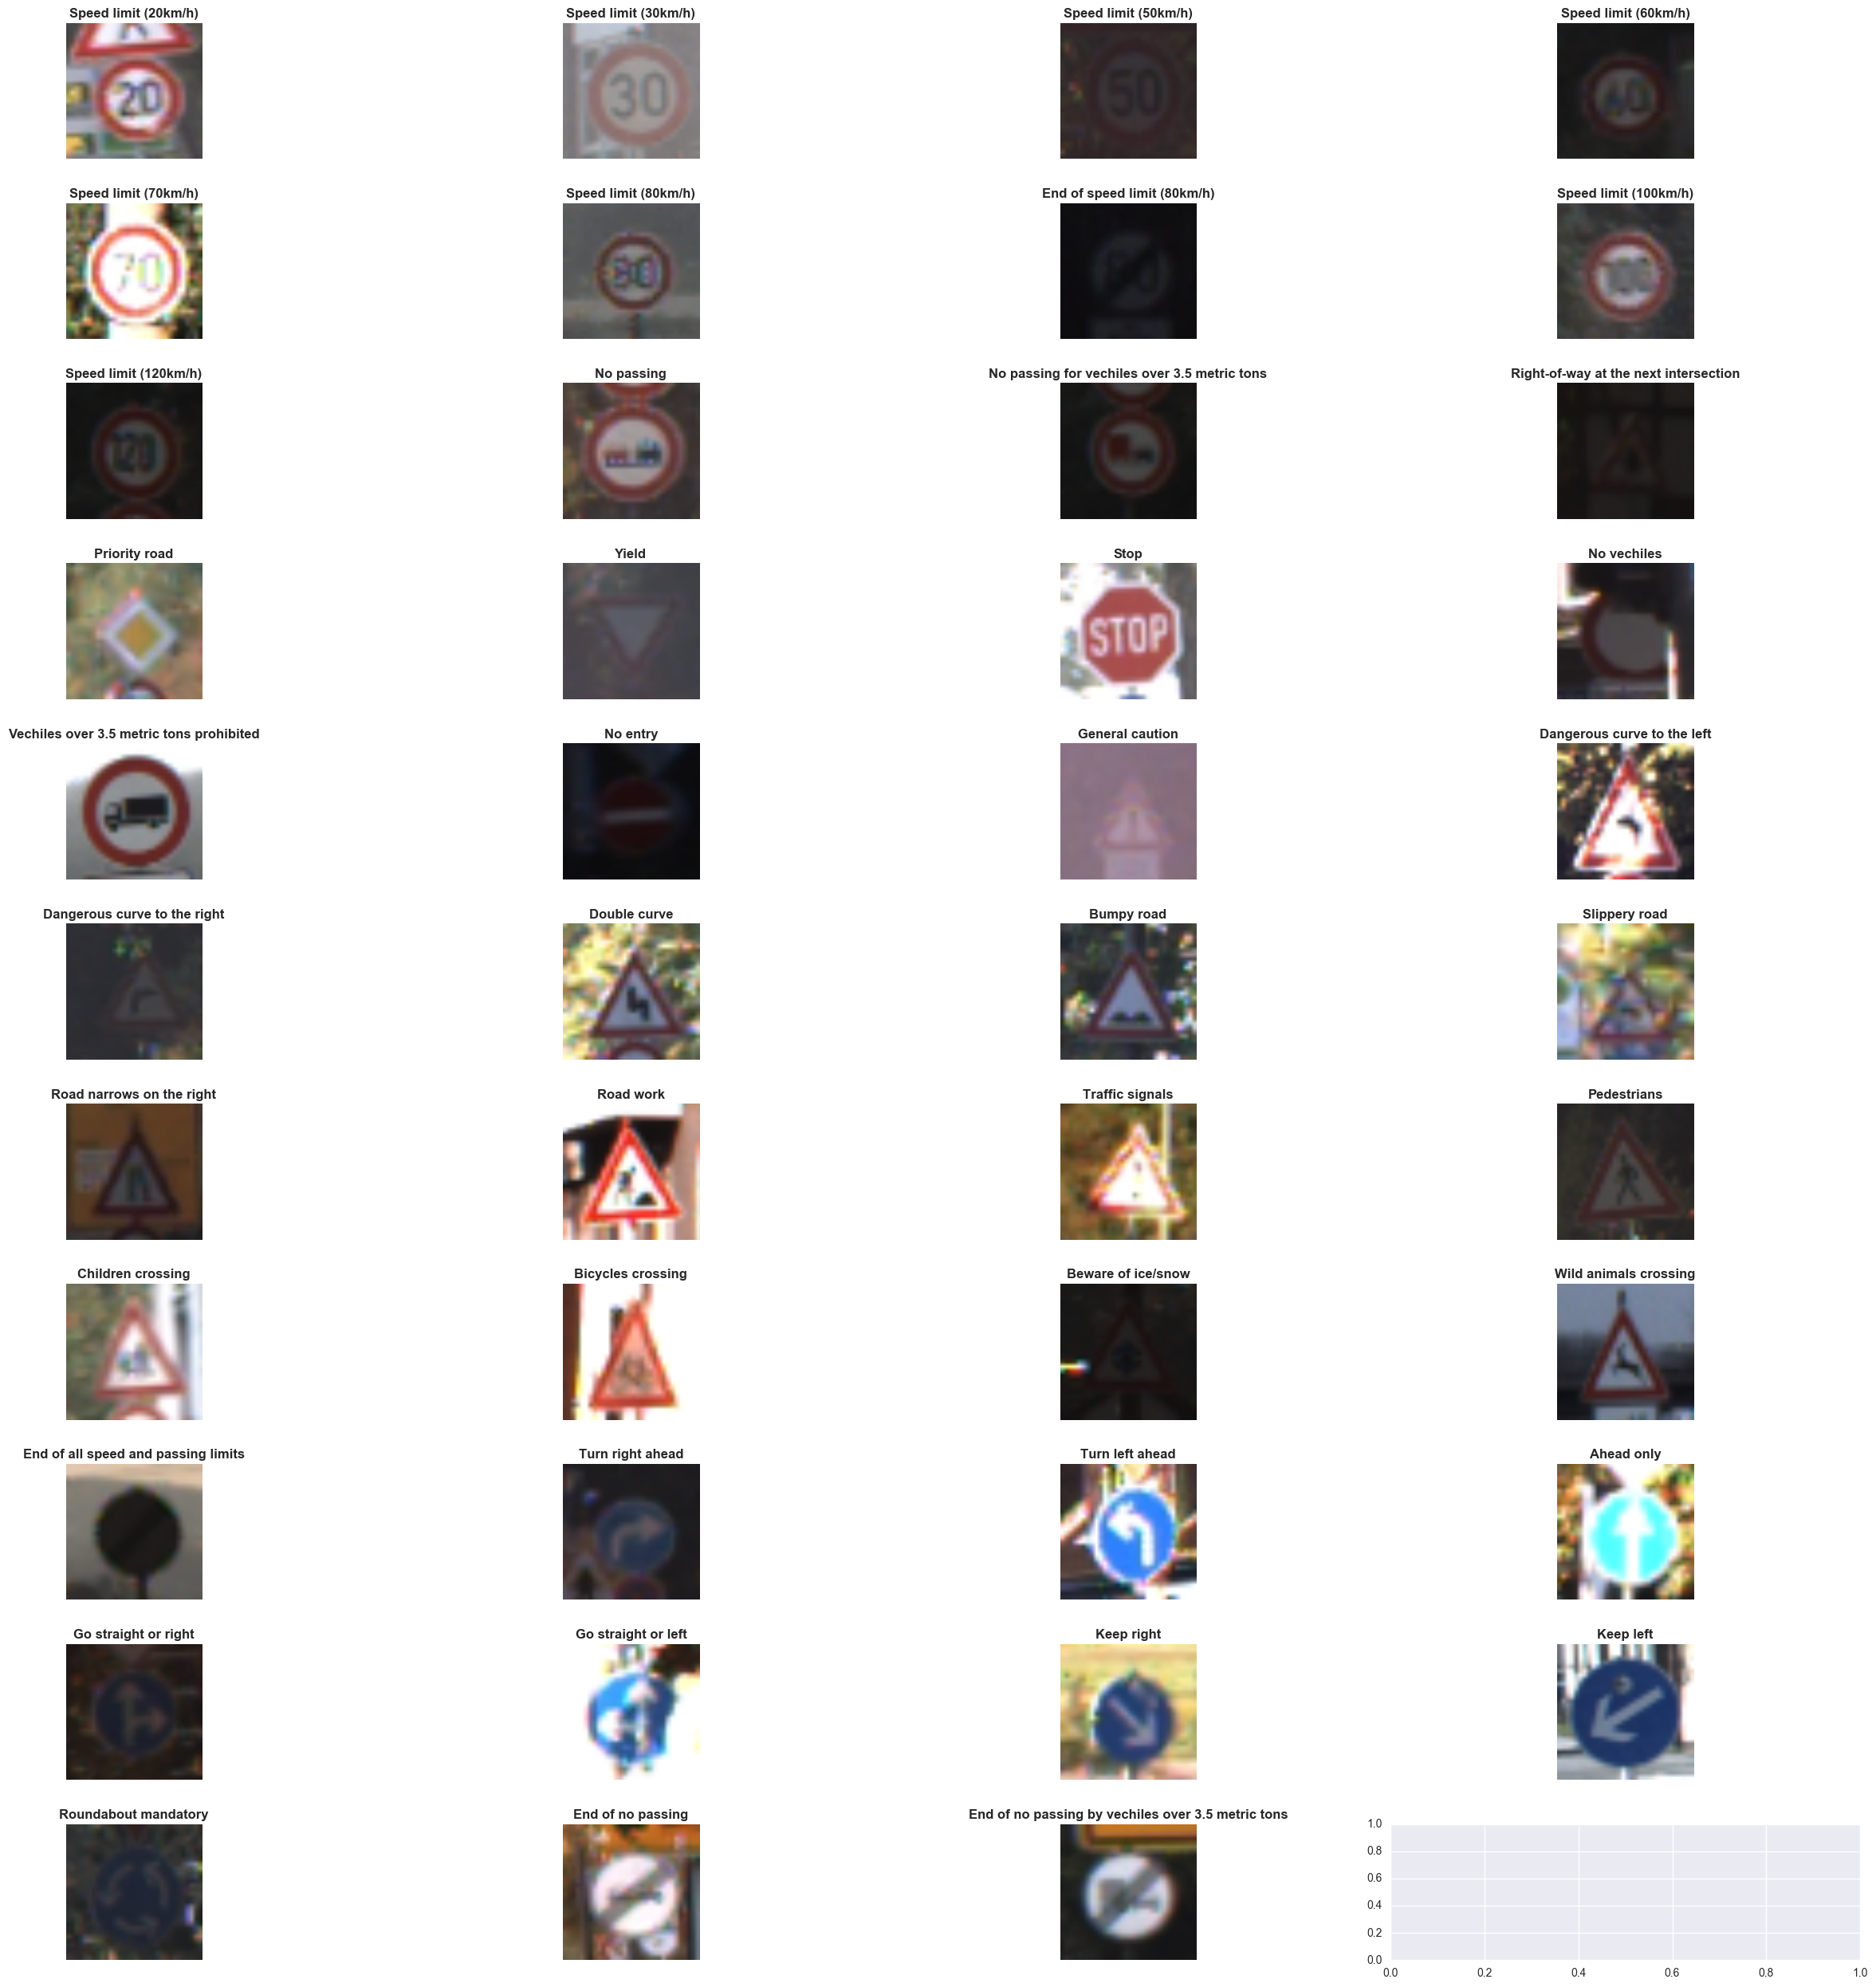

In [102]:
%matplotlib inline

# Read traffic sign class and name information.
sig_names = pd.read_csv('signnames.csv')

# Loop over traffic sign classes and display them in a grid.
_, ax = plt.subplots(11,4,figsize=(25,25))
row_counter = 0
for class_id, sign_name in zip(sig_names.ClassId, sig_names.SignName):
    idx = np.where(y_train == class_id)[0][np.random.randint(0, 10)]
    # After every 4 images start a new row of images.
    if class_id % 4 == 0 and class_id > 0:
        row_counter += 1
    ax[row_counter, class_id % 4].imshow(X_train[idx])
    ax[row_counter, class_id % 4].set_title(sign_name, fontdict={'fontweight': 'bold'})
    ax[row_counter, class_id % 4].grid(False)
    ax[row_counter, class_id % 4].axis('off')
plt.tight_layout()

## Generate bar plot of the count of each traffic sign class in training dataset

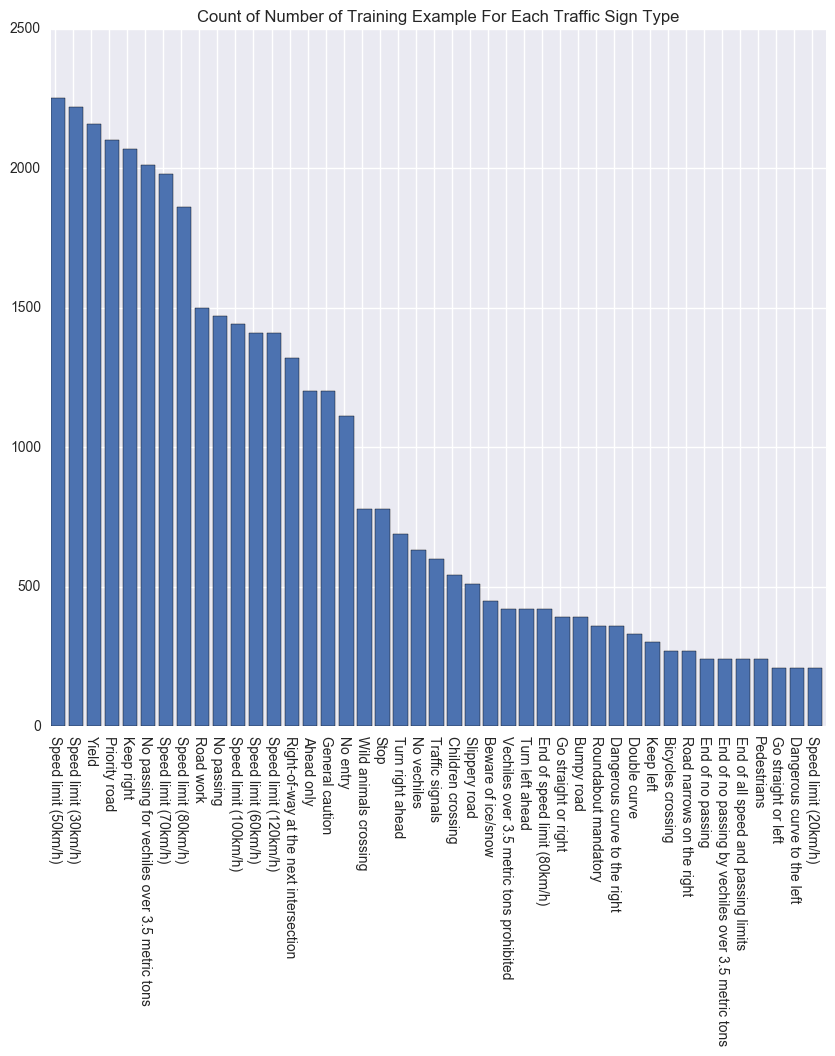

In [103]:
# Get a count of each traffic sign class.
train_label_counts = pd.Series(y_train, name='LabelCount').value_counts().sort_index()

# Merge sorted traffic sign class counts with traffic sign names and sort by class counts.
train_label_counts_names = sig_names.set_index('ClassId').join(train_label_counts).sort_values(
    'LabelCount', ascending=False)

# Generate Barplot of class counts.  From the plot below, we clearly see we have class imbalance.
plt.figure(figsize=(10,9))
plt.bar(np.arange(n_classes), train_label_counts_names.LabelCount)
plt.xticks(np.arange(n_classes)+0.25, train_label_counts_names.SignName, rotation=-90)
plt.title('Count of Number of Training Example For Each Traffic Sign Type')
plt.xlim([0, n_classes])
plt.grid(True)
plt.show()

## <font color='red'>Visualize prevalence of each traffic signs in train and test datasets.</font>
#### <font color='red'>From the plot below we can see that the prevalence of each traffic sign is similar across the provided training and testing datasets.</font>

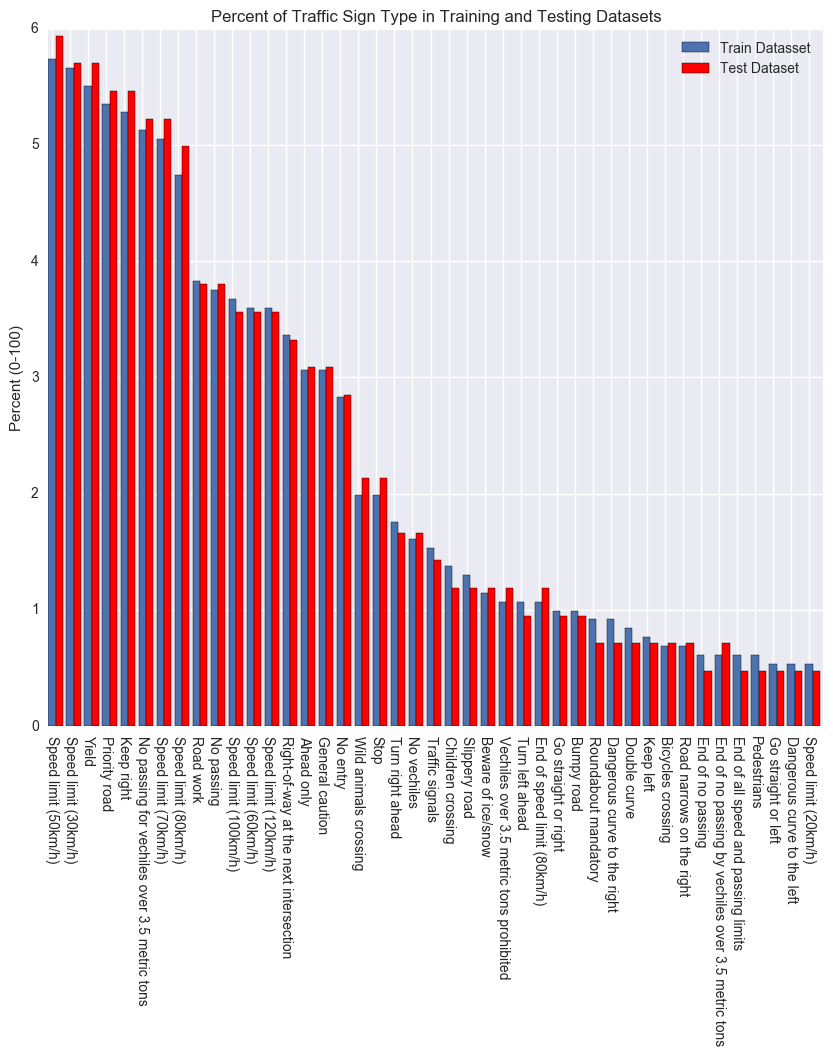

In [104]:
# Get a count of each traffic sign class in the test dataset and merge with traffic sign names.
test_label_counts = pd.Series(y_test, name='LabelCount').value_counts().sort_index()
test_label_counts_names = sig_names.set_index('ClassId').join(test_label_counts).sort_values(
    'LabelCount', ascending=False)

# Compute percentage of each traffic sign in the train and test datasets.
test_label_counts_names['LabelPercent'] = 100 * test_label_counts_names['LabelCount'] / test_label_counts_names['LabelCount'].sum()
train_label_counts_names['LabelPercent'] = 100 * train_label_counts_names['LabelCount'] / train_label_counts_names['LabelCount'].sum()

# Join dataframes with traffic sign percentages.
train_test_label_percent = train_label_counts_names.join(test_label_counts_names, lsuffix='_Train', rsuffix='_Test')
train_test_label_percent = train_test_label_percent[['SignName_Train', 'LabelPercent_Train', 'LabelPercent_Test']]

# Generate Barplot of comparing class pervalence in train/test sets. 
plt.figure(figsize=(10,9))
plt.bar(2.5*np.arange(n_classes), train_test_label_percent.LabelPercent_Train, width=1)
plt.bar(2.5*np.arange(n_classes) + 1, train_test_label_percent.LabelPercent_Test, width=1, color='r')
plt.xticks(2.5*np.arange(n_classes) + 0.5, train_test_label_percent.SignName_Train, rotation=-90)
plt.title('Percent of Traffic Sign Type in Training and Testing Datasets')
plt.ylabel('Percent (0-100)')
plt.xlim([0, 2.5*n_classes])
plt.legend(['Train Datasset', 'Test Dataset'])
plt.grid(True)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

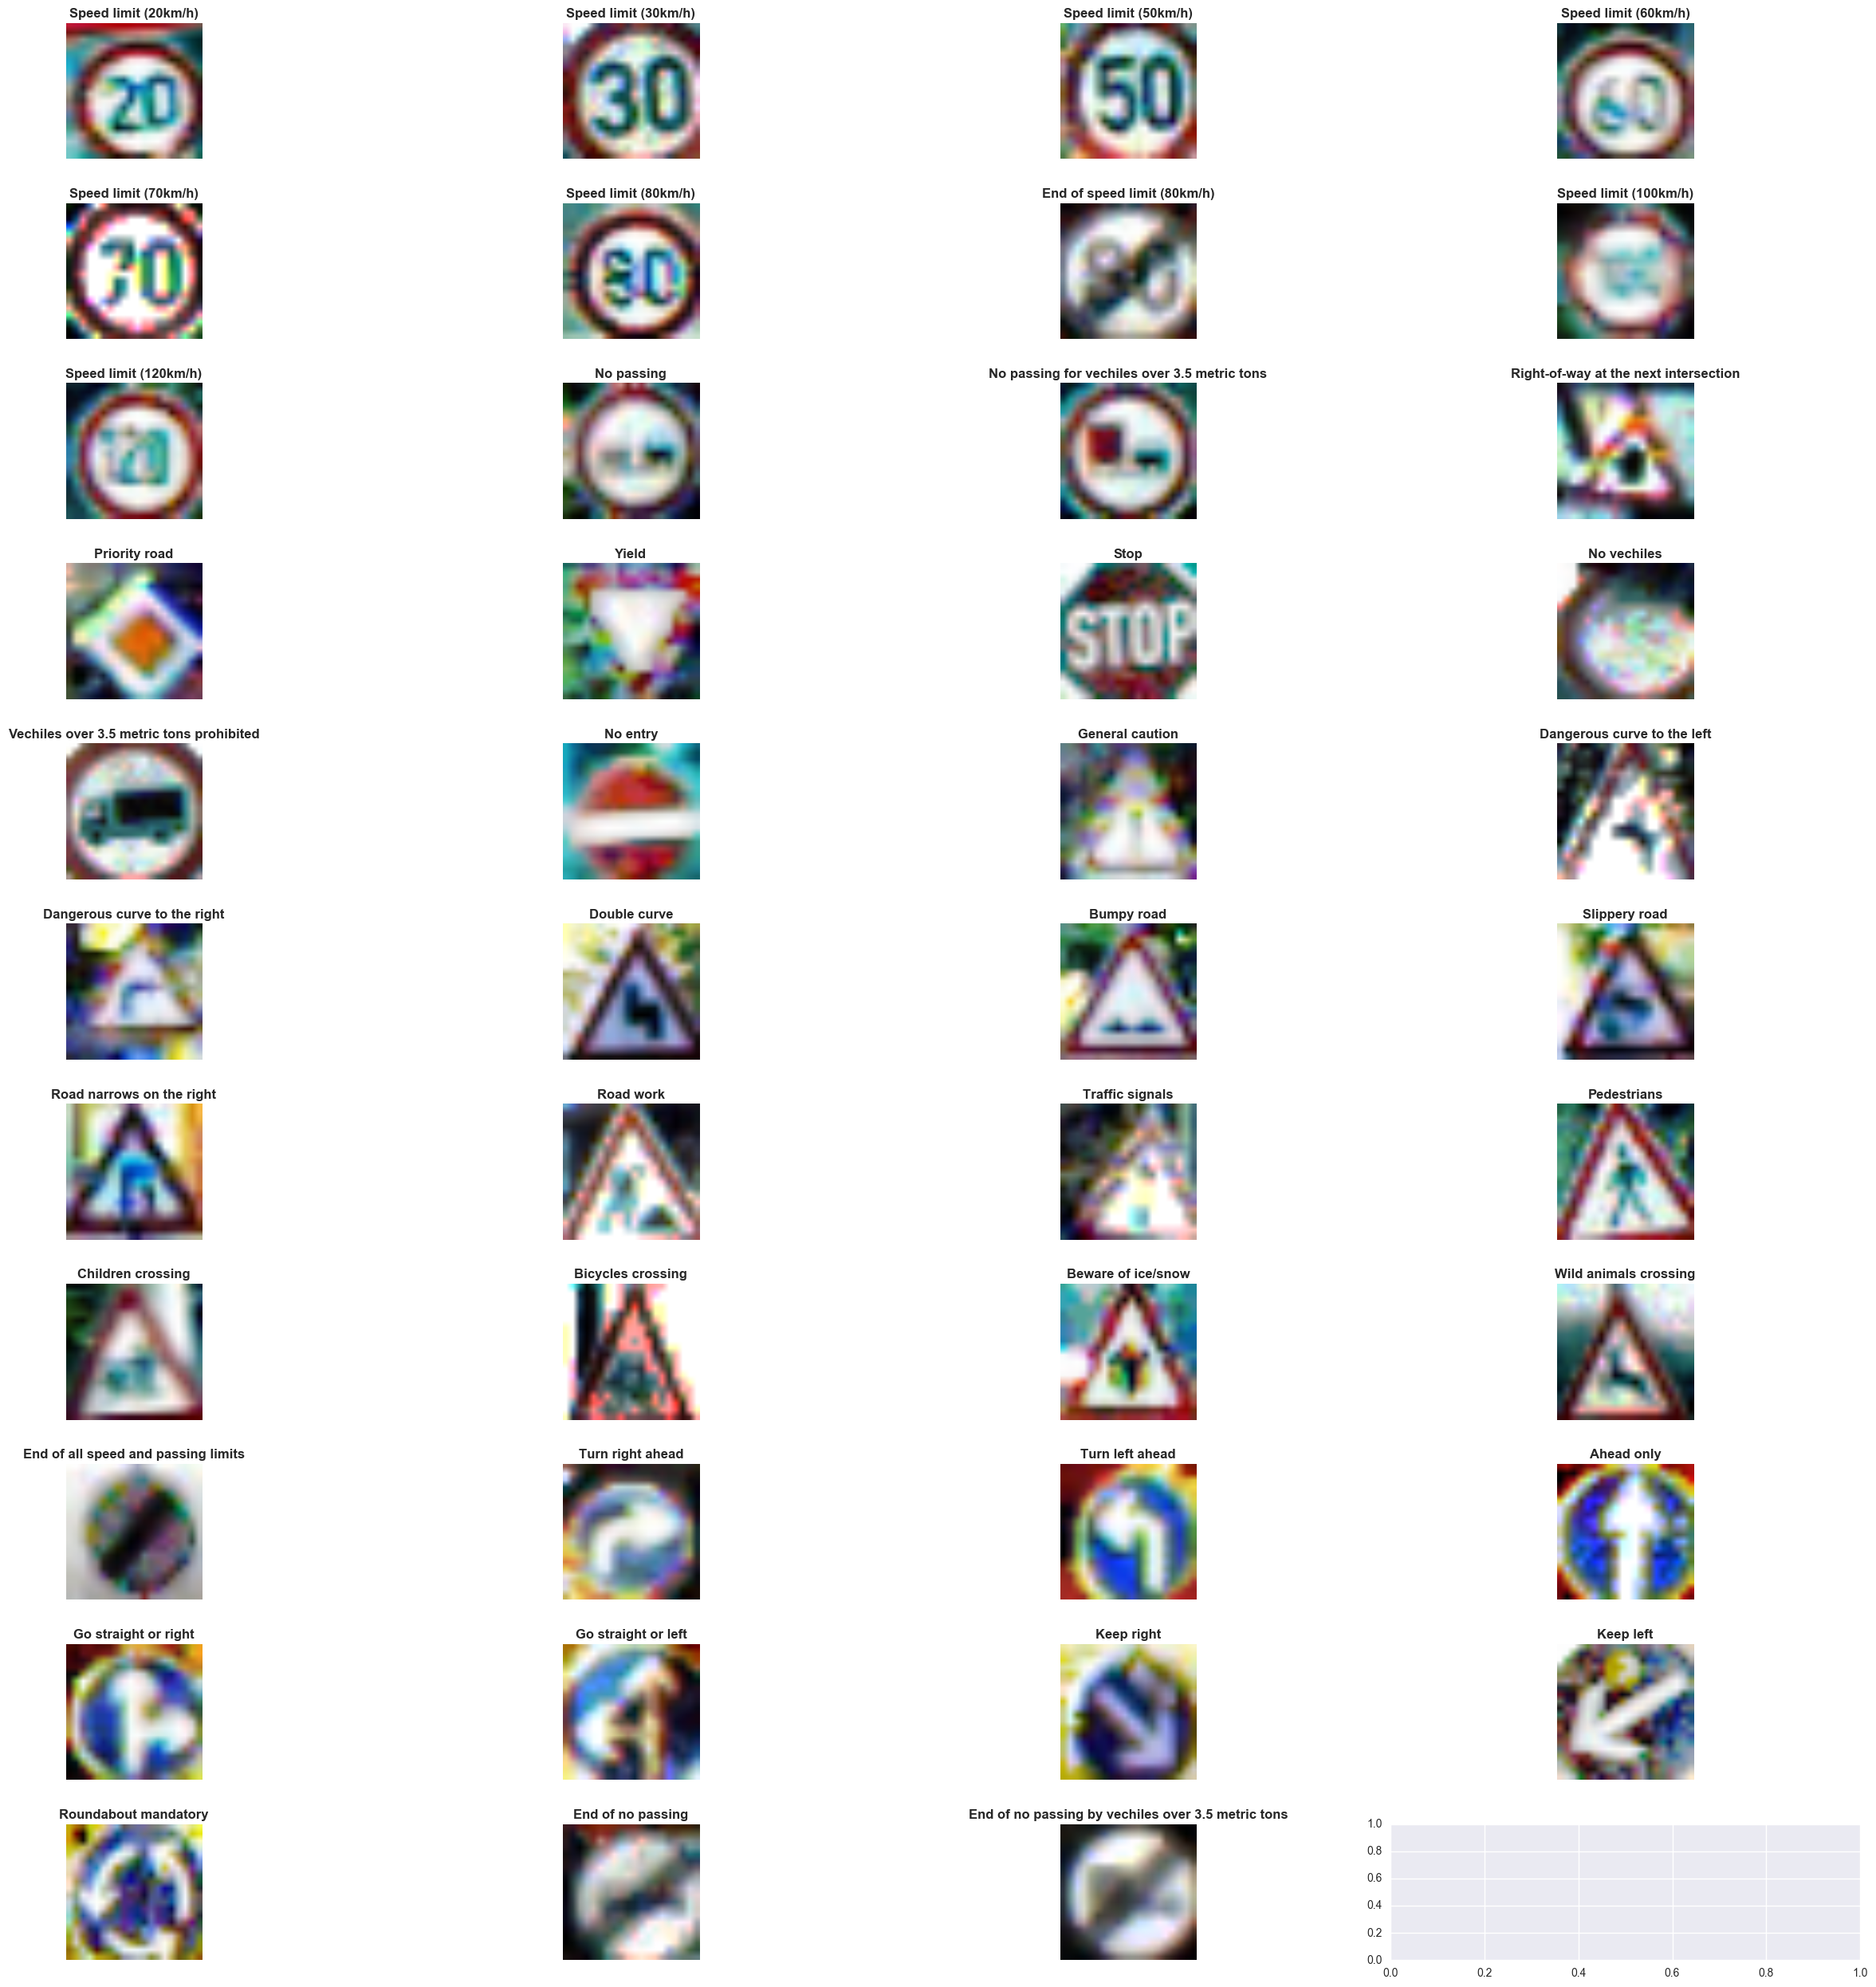

In [105]:
# Preprocessing  

# Centrally crops images and performs histogram equalization.
def EqualizeAndCropImage(img, num_pixels=6):
    """Performs histogram equalization and central cropping of an image.
    
    Args:
      img: A numpy array corresponding to an image with three color channels.
      num_pixels: The number of pixels to remove from the edges of the rows and 
        columns of the input image.
    Returns:
      A numpy array with the centrally cropped and equalized image.
    """
    return np.stack((exposure.equalize_hist(img[num_pixels:-num_pixels,num_pixels:-num_pixels,0]),
                     exposure.equalize_hist(img[num_pixels:-num_pixels,num_pixels:-num_pixels,1]),
                     exposure.equalize_hist(img[num_pixels:-num_pixels,num_pixels:-num_pixels,2])), axis=2)

def EqualizeAndCropImages(imgs, num_pixels=6):
    """Applies histogram equalization and central cropping for image in a list of images.
    
    Args:
      imgs: List with numpy arrays corresponding to images.
      num_pixels: The number of pixels to remove from the edges of the rows and 
        columns of the input image.
    Returns:
      Numpy array of images after histogram equalization and central cropping.
    """
    return np.array([EqualizeAndCropImage(img, num_pixels) for img in imgs])
        
# Normalize each image int the train and test sets.
X_train = EqualizeAndCropImages(X_train)
X_test = EqualizeAndCropImages(X_test)

# Loop over traffic sign classes and display preprocessed training images.
_, ax = plt.subplots(11,4,figsize=(25,25))
row_counter = 0
for class_id, sign_name in zip(sig_names.ClassId, sig_names.SignName):
    idx = np.where(y_train == class_id)[0][np.random.randint(0, 10)]
    # After every 4 images start a new row of images.
    if class_id % 4 == 0 and class_id > 0:
        row_counter += 1
    ax[row_counter, class_id % 4].imshow(X_train[idx])
    ax[row_counter, class_id % 4].set_title(sign_name, fontdict={'fontweight': 'bold'})
    ax[row_counter, class_id % 4].grid(False)
    ax[row_counter, class_id % 4].axis('off')
plt.tight_layout()

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**<br> 
As can be seen in the sample traffic sign images in cell #4, there is a great deal of variability in  image intensity and contrast.  In fact, some images are so dark that the traffic sign can barely be seen.  Moreover, there is unnecessary background in the 32X32 images of the 
traffic signs.  To alleviate both of these problems, my preprocessing included the following two operations: <br>
 1) <strong>Histogram Equalization</strong> to enahnce global contrast across all images. <br>
 2) <strong>Central Cropping</strong> to retain the middle 20X20 pixels. 

In [106]:
# Validaton and Testing Datasets.  
def SplitDataset(dataset, labels, classes, keep_fraction=0.80):
    """Splits a dataset so that keep_fraction samples from each class is used as validation and the rest as testing.
    
    Args:
      dataset: Numpy array of images.
      labels: Numpy array of labels associated with each input image.
      classes: Numpy array of class labels with no duplicates.
      keep_fraction: The percent of each class that will be retained for validation.
    """
    # Loop over each class and collect keep_fraction samples for validation from each class.
    validation_idx, test_idx,  = [[],[]]
    for class_id in classes:
        idx = np.where(labels == class_id)[0]
        num_examples = int(keep_fraction * len(idx))
        validation_idx.extend(idx[:num_examples])
        test_idx.extend(idx[num_examples:])
    validate = np.array([dataset[i] for i in validation_idx])
    validate_labels = np.array([labels[i] for i in validation_idx])
    test = np.array([dataset[i] for i in test_idx])
    test_labels = np.array([labels[i] for i in test_idx])
    return validate, validate_labels, test, test_labels, 

validation_X, validation_Y, test_X, test_Y = SplitDataset(X_test, y_test, sig_names.ClassId)

print("Validation Data Size: ", len(validation_X))
print("Test Data Size: ", len(test_X))

Validation Data Size:  10104
Test Data Size:  2526


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**<br>
I used the entirety of the training data (in train.p) for model training.  I split test data (test.p) into a validation and testing dataset.  I will use the validation dataset (80% of test.p) to test models with different hyperparameters.  Once satisified with my choice, I will test the model on the remaining 20% to ensure that the results hold and that I did not overfit to the validation dataset.  Since the dataset has severe class imbalance, I form the validation and testing datasets by adding 80% of each class to the validation dataset and the remaining 20% of each class to the testing dataset.  This strategy ensures that all classes are represented in the validation and testing datasets. 

In [107]:
### Define your architecture here.
class BatchReader():
    """This class produces batches of images from a numpy array of images."""
    def __init__(self, samples, class_index, batch_size=10):
        """Constructor.
        
        Args:
          samples: Numpy array of images (from a single class) from which to draw samples.
          class_index: The class label (or index) associated with the samples.
          batch_size: The size (number of images) returned with each call of GetBatch().
        """
        self.data = samples
        self.batch_size = batch_size
        self.start_idx = 0
        self.class_index = class_index
        
    def _Get_OHE_Labels(self, start_idx, end_idx):
        """Returns One-Hot-Encoded (OHE) labels for a batch of images."""
        # Construct 1-hot encoded labels
        labels = np.zeros((end_idx-start_idx, 43))
        labels[:, self.class_index] = 1
        return labels
    
    def GetBatch(self):
        """Returns batch of images along with their One-Hot-Encoded labels."""
        start_idx = self.start_idx
        if start_idx + self.batch_size >= len(self.data):
            end_idx = len(self.data)
            self.start_idx = 0
        else:
            end_idx = start_idx + self.batch_size 
            self.start_idx += self.batch_size
        return self.data[start_idx:end_idx], self._Get_OHE_Labels(start_idx, end_idx)
    
def WeightVariable(shape):
    """Creates a Weight variable for use in a convolution or fully-connected layer.
    
    Args: 
      shape: List of integers specifying dimensions of weight variable.
    Returns:
      TensorFlow variable.
    """
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def BiasVariable(shape):
    """Creates a bias variable for use in a convolution or fully-connected layer.
    
    Args: 
      shape: List of integers specifying dimensions of weight variable.
    Returns:
      TensorFlow variable.
    """
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def Conv2D(x, W):
    """Performs 2D convolution of tensor x with kernel W"""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def MaxPool_2x2(x):
    """Performs 2D max-pooling with 2X2 Kernel."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def Loss(y_hat, y_true):
    """Evaluates Cross-Entropy Loss."""
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_hat, y_true))
    return cross_entropy_loss

def Optimizer(loss, learning_rate=5e-3):
    """Returns an Optimizer to minimize supplied loss function."""
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return optimizer

def Accuracy(y_hat, y_true):
    "Evaluates accuracy of supplied batch of predictions (y_hat) and labels (y_true)."
    correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y_true,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

def TrafficSignClassifier(model_inputs, keep_prob, n_classes=43):
    """Defines convolutional neural network for classifying traffic sign images.
    
    This method defines a neural network with 3 Convolutional Layers followed by two
    Fully-Connected layers.
    
    Args:
      model_inputs: Place holder for feeding model input images.
      keep_prob: Place holder for defining Dropout Layer keep probability.
      n_classes: Number of target classes.
    Returns:
      Tensor of logit scores, and top_5 probabilities for each input in the batch.
    """
    # First Convolutional Layer.  Input is 20 x 20 x 3
    w_conv1 = WeightVariable([7, 7, 3, 16])
    b_conv1 = BiasVariable([16])
    h_conv1 = tf.nn.relu(Conv2D(model_inputs, w_conv1) + b_conv1)
    h_pool1 = MaxPool_2x2(h_conv1)
    
    # Second Convolutional Layer.  Input is 10 x 10 x 16
    w_conv2 = WeightVariable([5, 5, 16, 32])
    b_conv2 = BiasVariable([32])
    h_conv2 = tf.nn.relu(Conv2D(h_pool1, w_conv2) + b_conv2)
    h_pool2 = MaxPool_2x2(h_conv2)
    
    # Third Convolutional Layer.  Input is 5 x 5 x 32
    w_conv3 = WeightVariable([3, 3, 32, 64])
    b_conv3 = BiasVariable([64])
    h_conv3 = tf.nn.relu(Conv2D(h_pool2, w_conv3) + b_conv3)
    h_pool3 = MaxPool_2x2(h_conv3)
    
    # Dense Layer.  Input is 3 x  3 x 64
    w_fc1 = WeightVariable([3 * 3 * 64, 128])
    b_fc1 = BiasVariable([128])
    h_pool3_flat = tf.reshape(h_pool3, [-1, 3 * 3 * 64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, w_fc1) + b_fc1)
    
    # Dense Layer.  Input is 1 x 128
    w_fc2 = WeightVariable([128, 256])
    b_fc2 = BiasVariable([256])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, w_fc2) + b_fc2)
    
    # Dropout.  Input is 1 x 256
    h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)
    
    # Readout Layer
    w_fc4 = WeightVariable([256, n_classes])
    b_fc4 = BiasVariable([n_classes])
    logits = tf.matmul(h_fc2_drop, w_fc4) + b_fc4
    probabilities = tf.nn.softmax(logits)
    top_k_scores = tf.nn.top_k(probabilities, k=5)
    
    return logits, top_k_scores

def GetTrafficSignClassifier(n_classes=43):
    """Defines graph for training and evaluating TrafficSignClassifier."""
    # Input image place holder.
    inputs_pl = tf.placeholder(tf.float32, shape=[None, 20, 20, 3])
    # Input image label place holder.
    target_pl = tf.placeholder(tf.float32, shape=[None, n_classes])
    # Droptout layer keep probability place holder.
    keep_prob_pl = tf.placeholder(tf.float32)
    # Classifier logit scores
    logits, top_k_scores = TrafficSignClassifier(inputs_pl, keep_prob_pl)
    # Loss operation.
    loss_op = Loss(logits, target_pl)
    # Accuracy operation.
    accuracy_op = Accuracy(logits, target_pl)
    # Optimizer operation.
    trainer_op = Optimizer(loss_op)
    return inputs_pl, target_pl, keep_prob_pl, trainer_op, accuracy_op, logits, top_k_scores

def GetBatchReaders(data, labels, n_classes=43):
    """Returns list containing a BatchReader for each class."""
    batch_readers = []
    for i in range(n_classes):
        batch_readers.append(BatchReader(data[labels == i], i))
    return batch_readers

### Model Training and Evaluation Loop 
### <font color='red'>92.3%</font> Validation Accuracy @ <font color='red'>2000</font> Steps with batches contianing 10 samples from each class

In [140]:
# Construct Model Graph
inputs_pl, target_pl, keep_prob_pl, train_op, accuracy_op, logits, top_k_scores = GetTrafficSignClassifier()

# Get batch readers for training dataset.
batch_readers = GetBatchReaders(X_train, y_train)

# Generate one-hot-encoded labels for validation dataset.
validate_Y_ohe = (np.array(validation_Y)[:,np.newaxis] == np.arange(43)).astype(float)

with tf.Session() as sess:
    # Add a Saver to save model checkpoint.
    saver = tf.train.Saver()
    
    # Initialize variables
    sess.run(tf.initialize_all_variables())

    # Take 2000 training steps.
    for i in range(2001):

        # Assemble a batch of training data and labels.  A batch contains 10 
        # examples from each of the traffic sign classes.
        batch = None
        batch_labels =  None
        for k in range(43):
            x,y = batch_readers[k].GetBatch()
            if batch is None:
                batch = x
                batch_labels = y
            else:
                batch = np.concatenate((batch, x), axis=0)
                batch_labels = np.concatenate((batch_labels, y), axis=0)

        # Train model on assembled batch.
        _, train_accuracy = sess.run([train_op, accuracy_op], feed_dict={inputs_pl: batch, 
                                                                         target_pl: batch_labels, 
                                                                         keep_prob_pl:0.95})

        # After every 500 steps, evaluate model on the validation data.
        if i % 500 == 0:
            validation_accuracy = sess.run([accuracy_op], feed_dict={inputs_pl: validation_X,
                                                                     target_pl: validate_Y_ohe,
                                                                     keep_prob_pl: 1.0})[0]
            # Print model progress.
            print('Train Accuracy: %f | Validation Accuracy %f | Step %d' % (train_accuracy,validation_accuracy,i))

    # Save the model
    saver.save(sess, "model.ckpt")

Train Accuracy: 0.027907 | Validation Accuracy 0.010590 | Step 0
Train Accuracy: 0.986046 | Validation Accuracy 0.877375 | Step 500
Train Accuracy: 0.990698 | Validation Accuracy 0.907462 | Step 1000
Train Accuracy: 0.932558 | Validation Accuracy 0.924881 | Step 1500
Train Accuracy: 0.993007 | Validation Accuracy 0.923199 | Step 2000


## Evaluate model on Test Dataset
### <font color='red'>91.7%</font> Test Accuracy

In [141]:
# Generate one-hot-encoded labels for test dataset.
test_Y_ohe = (np.array(test_Y)[:,np.newaxis] == np.arange(43)).astype(float)

# Evaluate accuracy on test dataset
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "model.ckpt")
    test_accuracy = sess.run([accuracy_op], feed_dict={inputs_pl: test_X, target_pl: test_Y_ohe, keep_prob_pl: 1.0})[0]
    print('Test Accuracy: %f' % test_accuracy)

Test Accuracy: 0.917656


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**<br>
My convolutional neural network uses an architecture that progressively transforms the input from a representation that is "wide and shallow" (e.g. input is 20 X 20 X 3 which is large in height and width but shallow in depth) to a representation that is "narrow and deep" (e.g. the output of my last convolutional layer is 3 X 3 X 64).  Each additional depth dimension is a learned feature map that helps the network solve the classification task.
<br>
<br>
Specifically, my architecture contains three successive convolutional layers followed by two successive fully-connected layers.  Each convolutional layer employs a ReLU activation function, <font color='red'>"SAME" padding</font>, and 2X2 max-pooling with a stride of 2 in each dimension.  During training, the output of the second fully-connected layer passes through a dropout layer prior to being fed into the model's output layer (the layer that produces the logit scores for the 43 classes).  
<br>
<br>
To go from "wide and shallow" to "narrow and deep", the number of feature maps doubles between each layer of the model as the dimensions are halved (due to the stride of the max pooling layers).  So we start with 10X10X16 feature maps at the output of the first convolutional layer, 5X5X32 at the output of the second, 3X3X64 at the output of the third.  The number of output nodes generated by the fully-connected layers also follows this pattern.  So the output of the first fully-connected layer is 128 while the output of the second is 256.  The model's final layer maps these 256 values to 43 logit scores.
<br>
<br>
The filters employed by the convolutional layers are also progressively shrunk to accomodate the halving of the spatial dimensions between model layers.  So, we start with 7X7 filters in the first convolutional layer, 5X5 in the second convolutional layers, and 3X3 in the third and last convolutional layer.
<br>
<br>
<font color='red'>The image below depicts the architecture of my neural network and hightlights the size of the tensors and kernels at different points along the network.</font>
<br>
<img src='./nn_img.png'>

### Question 4

How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)

**Answer:**<br>
To train the model, I used an AdamOptimizer because it employs an adaptive learning rate as well as "momentum" when updating model parameters.  These two features make it more effective as an optimizer when compared to stochastic gradient descent.

Since there is significant class imbalance in this datasest, I paid close attention to how I constructed the batches used during each step of model training.  Specifically, I constructed the batches so that each class contributed and equal number of samples to a batch.  Specifically, each class contributed 10 samples making each training batch 430 samples large.

Using the validation set, I experimented with the number of convolutional layers, the number of fully-connected layers, and the dropout probability.  I ultimatly arrived at 3 convolutional layers, 2 fully-connected layers, and a dropout probability of 0.95.  This ultimatly gave me <font color='red'>~92.3%</font> accuracy on the validation dataset and <font color='red'>91.7%</font> on the test set.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**<br>
<font color='red'>I chose to solve this problem using a multi-layered convolutional neural network with an architecture similar to the LeNet ConvNet (ie. a series of convolutinal and max-pooling layers followed by fully-connected layers).  This neural network architecture is well-suited for this problem because the convolutional layers learn features that are insensitive to shifts in position (meaning I should be able to recognize a traffic sign whether it is in the center or the corner of an image).  The max-pooling layers allow us to downsample the output of the convolutional layer in a manner that adds invariance to input shifts and only keeps maximal values (downsampling helps subsequent layers by reducing the size of their inputs and hence the parameters that need to be learned).  The fully-connected layers condense all of the features gathered in the preceding layers into a feature vector that can be used for assigning a class to the input image.</font>  However, <font color='red'>experimenting with architectures</font> was not enough as that got me only up to an accuracy of ~85-88%.  I then turned to thinking about how to better preprocess my images so as to help the network learn more effectively.  Centrally cropping the images after histogram equalization, which removes the confounding background pixels, provided me a big boost in performance (92-94%).

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**<br>
The two cells below illustrate the traffic sign images I downloaded from the web to test my trained model.  <font color='red'> To classify these web images using the model trained on the Germain Traffic Sign dataset, I proprocess these images using the same methodology applied to the training dataset.   This includes 1) Centrally Cropping a 20X20 region of the image 2) Histogram Equalization. </font> 

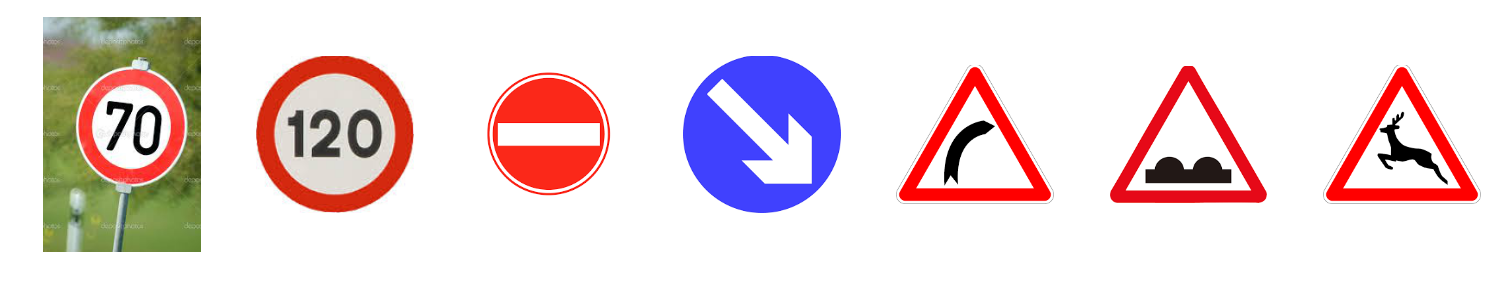

In [136]:
### Load the images and plot them here.
_, ax = plt.subplots(1,7,figsize=(15,15))
web_imgs = []
for idx, image_path in enumerate(glob.glob('./Image*')):
    img = imread(image_path)
    web_imgs.append(img)
    ax[idx % 7].imshow(web_imgs[-1])
    ax[idx % 7].grid(False)
    ax[idx % 7].axis('off')
plt.tight_layout()

In [137]:
# Preprocess images to so they match size expected by model and are histogram equalized.
processed_web_imgs = [EqualizeAndCropImage(resize(img, (32,32))) for img in web_imgs]

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**<br>
As can be seen below, the model does very well on the sampled web images.  It correctly classifies <font color='red'>6</font> of 7 of the images.  For each image, the class name and probability predicted by the model are the image title.  For instance, the <font color='red'> image at (row=1, col=0), is a "No Entry" traffic sign that the model correctly classifies with a probability of 0.999</font>.  The model mistakenly classified the <font color='red'> "70 km/hour speed limit" sign (row=0, col=0) as a "30 km/hour speed limit" sign with high confidence (so the model was <strong> very wrong </storng>)</font>.  

The model's accuracy on this (small) web image set is 6 of 7 and its predicted accuracy (give the test set performance above) would be 6 of 7.  So the model does a pretty good job generalizing in this case.  <font color='red'> The model did so well because the test images are of traffic sign types similar to those in the training set and all but one of the images have no background.  In fact, the only mistake that this model had was on the test image with rich background colors.</font>



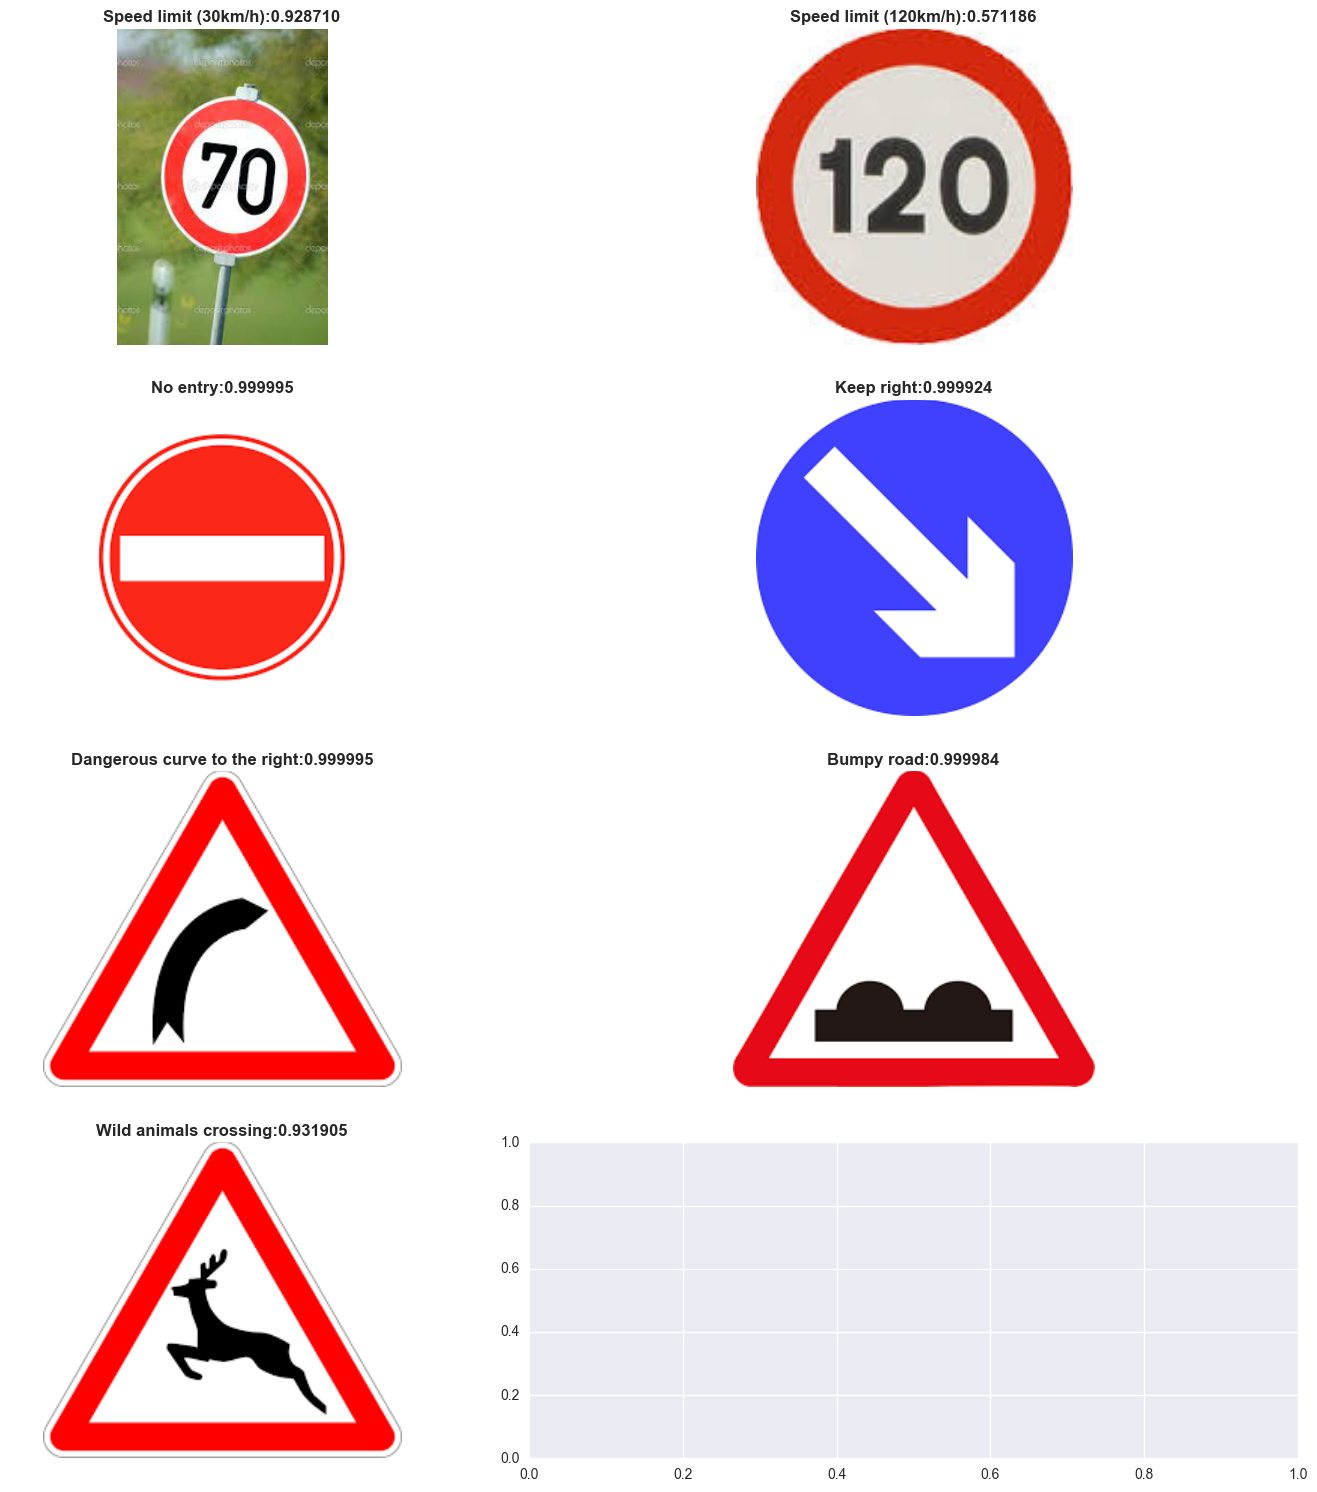

In [138]:
### Run the predictions here.
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "model.ckpt")
    logits_scores, top_k = sess.run([logits, top_k_scores], feed_dict={inputs_pl: np.array(processed_web_imgs), 
                                                                       keep_prob_pl: 1.0})
    
_, ax = plt.subplots(4,2,figsize=(15,15))
row_counter = 0
for idx, web_img in enumerate(web_imgs):
    if idx % 2 == 0 and idx > 0:
        row_counter += 1
    ax[row_counter, idx % 2].imshow(web_img)
    ax[row_counter, idx % 2].grid(False)
    top_5_scores = top_k[0][idx].ravel()[:1]
    top_5_names = sig_names.ix[top_k[1][idx].ravel()[:1]].SignName
    names_and_scores = ' | '.join(['%s:%f' % (name, score) for name, score in  zip(top_5_names, top_5_scores)])
    ax[row_counter, idx % 2].set_title('%s' % names_and_scores, fontdict={'fontweight': 'bold'})
    ax[row_counter, idx % 2].axis('off')
plt.tight_layout()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**<br>
<font color='red'>Next to each web image is a bar plot of the probability the classifier assigns to the top 5 predicted traffic sign classes.  We can now see that for the error described above (image of "70 km/hour speed limit" mistakenly labeled as "30 km/hour speed limit") the model had the correct answer among its top 5 answers (but it had very low confidence on the correct label of "70 km/hour").</font>  So, if our criterion was top-5 accuracy (ie. is the correct answer in the top-5), the model would have been 7 for 7 on this dataset (that being said, top-5 accuracy as an evaluation criterion would be a poor choice for a traffic sign classifier).

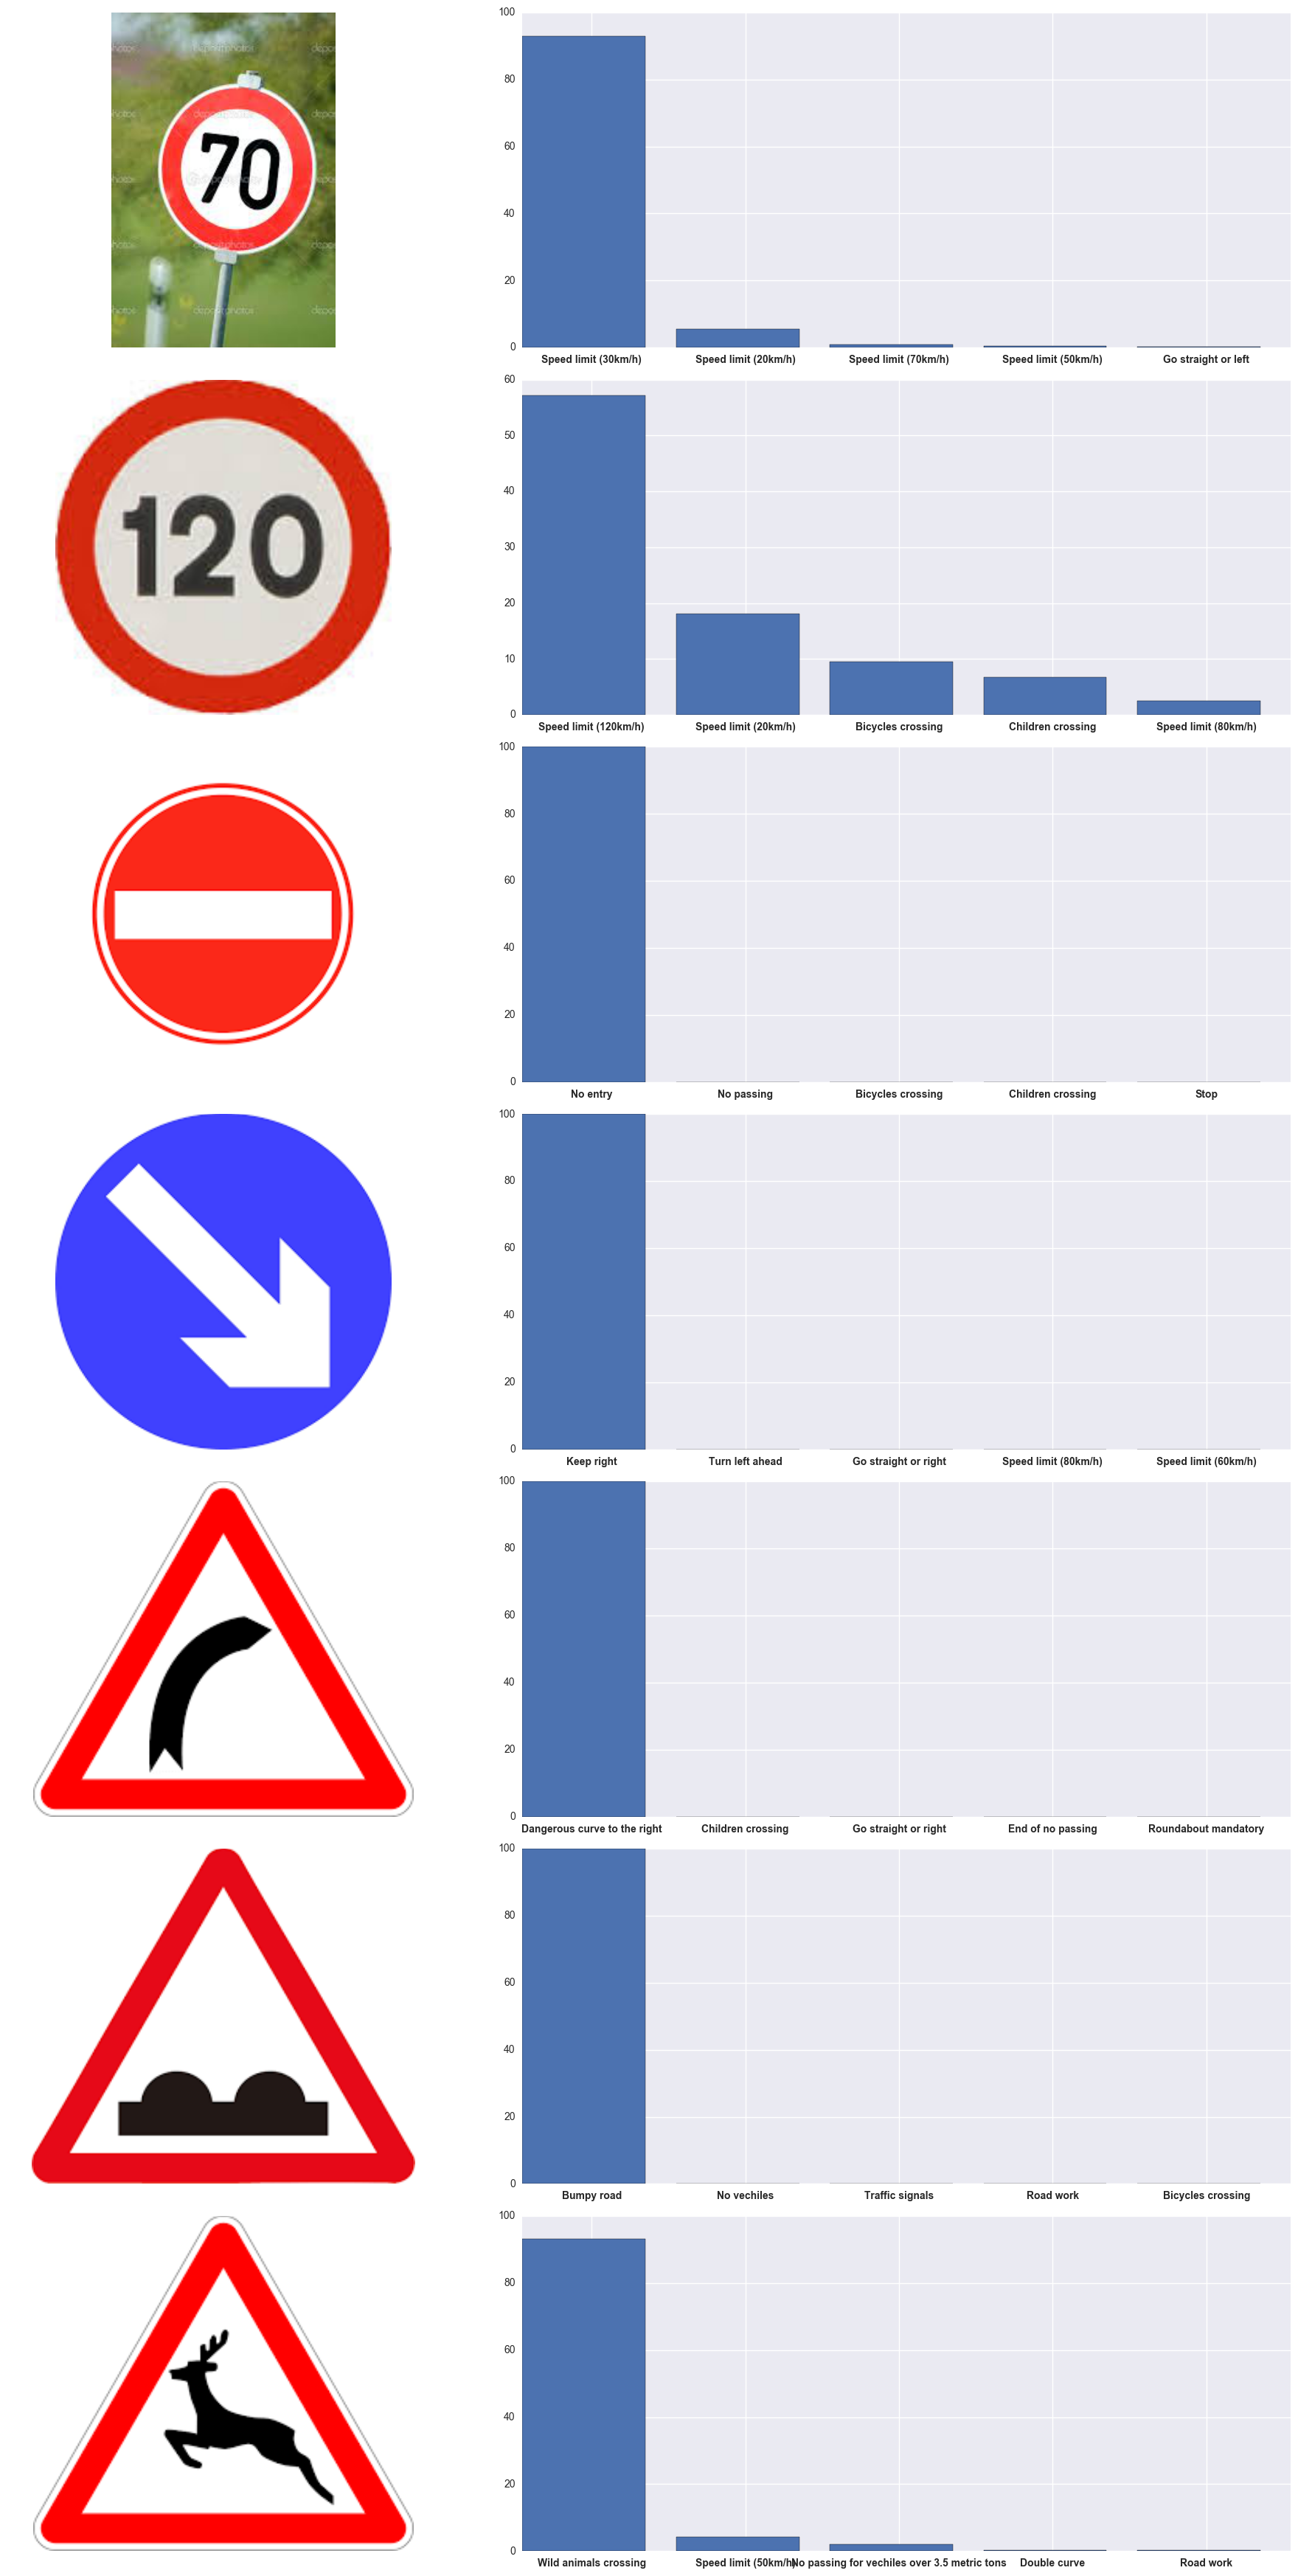

In [139]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
_, ax = plt.subplots(7,2,figsize=(20,35))
for idx, web_img in enumerate(web_imgs):
    ax[idx % 7, 0].imshow(web_img)
    ax[idx % 7, 0].grid(False)   
    ax[idx % 7, 0].axis('off')
    top_5_scores = top_k[0][idx].ravel()
    top_5_names = sig_names.ix[top_k[1][idx].ravel()].SignName
    ax[idx % 7, 1].bar(np.arange(5), top_5_scores * 100)
    ax[idx % 7, 1].set_xticklabels(top_5_names, fontdict={'fontweight': 'bold'})
    ax[idx % 7, 1].set_xticks(np.arange(5)+0.45)
plt.tight_layout()

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**<br>
In order to run the model on web images, I saved a model checkpoint after training.  Using the checkpoint, I could reload my model variables and evaluate the model's output node (which gives me the top-5 classes and their probabilities).

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.